In [12]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt


In [2]:
# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# Define the replay buffer class
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, transition):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return batch

In [4]:
# Define the DQN agent class
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01, batch_size=64, buffer_size=10000):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = ReplayBuffer(buffer_size)
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.target_optimizer = optim.Adam(self.target_net.parameters(), lr=lr)
        self.epsilon_decay_list = []  # List to store epsilon values

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item()

    def memorize(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))


    def train_agent(self, timestep):
        if len(self.memory.buffer) < self.batch_size:
            return

        # Sample a batch from the replay buffer
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Compute Q-values for the current states and selected actions
        current_q_values = self.policy_net(states).gather(1, actions)

        # Compute target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Calculate the loss using the Huber loss function
        loss = F.smooth_l1_loss(current_q_values, target_q_values.detach())

        # Perform backward pass and update weights of the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Perform epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            self.epsilon_decay_list.append(self.epsilon)

        # Periodically update the target network weights to the policy network weights
        if timestep % 100 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())



In [5]:
# Function to simulate the pendulum dynamics
def simulate_pendulum(state, action, mass, length, damping):
    dt = 0.1  # Time step
    gravity = 9.81  # Acceleration due to gravity

    cos_theta, sin_theta, theta_dot = state
    torque = 2*(action[0]-500)/1000  # Assuming action is a single value

    # Calculate theta from cos(theta) and sin(theta)
    theta = np.arctan2(sin_theta, cos_theta)

    # Calculate moment of inertia
    inertia = mass * length**2

    # Calculate angular acceleration
    alpha = (torque - gravity * np.sin(theta) * length - damping * theta_dot) / inertia

    # Update theta and theta_dot
    next_theta = theta + theta_dot * dt
    next_theta_dot = theta_dot + alpha * dt

    # Convert theta back to cos(theta) and sin(theta)
    next_cos_theta = np.cos(next_theta)
    next_sin_theta = np.sin(next_theta)

    return np.array([next_cos_theta, next_sin_theta, next_theta_dot])


In [11]:
# Main training loop
if __name__ == '__main__':
    num_actions = 1000
    agent = DQNAgent(state_dim=3, action_dim=num_actions)

    EPISODES = 1000
    print_once = True
    score_list = []

    for EP in range(EPISODES):
        # Initial state at theta = 0
        state = np.array([1.0, 0.0, 0.0])  # [cos(theta), sin(theta), theta_dot]
        score, done = 0.0, False

        # randomly select the mass and length of the pendulum
        mass = 1.5
        length = 0.8
        b = 0.2

        timestep = 0
        while not done:
            epsilon = max(0.1, 0.9 - 0.01 * EP)  # Linearly anneal epsilon
            action = agent.choose_action(state)
            # print("chosen action : ",action)

            # Simulate the pendulum dynamics
            next_state = simulate_pendulum(state, [action], mass, length, b)

            # Calculate reward based on angle deviation and angular velocity
            angle_deviation = np.arccos(next_state[0]) - np.pi  # [-pi, pi]
            reward = -angle_deviation ** 2 - 0.1 * next_state[2] ** 2  # Reward function

            # if (timestep%500==0):
              # print("angle dev. : ",angle_deviation,"\t velocity : ",next_state[2])
            # Terminate if we get the angle at pi and angular velocity = 0
            if np.abs(angle_deviation) < 0.1 and np.abs(next_state[2]) < 0.1:
                done = True
                reward += 100

            agent.memorize(state, action, reward, next_state, done)
            agent.train_agent(timestep)

            score += reward
            state = next_state

            if len(agent.memory.buffer) == agent.batch_size:
                if print_once:
                    print("Training started!")
                print_once = False
            timestep = timestep + 1

        print("EP:{}, Avg_Score:{:.1f}".format(EP, score))
        score_list.append(score)



Training started!
EP:0, Avg_Score:-6056.4
EP:1, Avg_Score:-8398.0
EP:2, Avg_Score:-4351.5
EP:3, Avg_Score:-4689.5
EP:4, Avg_Score:-3928.9
EP:5, Avg_Score:-1791.8
EP:6, Avg_Score:-1696.4
EP:7, Avg_Score:-1867.2
EP:8, Avg_Score:-1708.2
EP:9, Avg_Score:-1065.9
EP:10, Avg_Score:-1282.7
EP:11, Avg_Score:-2930.6
EP:12, Avg_Score:-1504.2
EP:13, Avg_Score:-2827.8
EP:14, Avg_Score:-1408.1
EP:15, Avg_Score:-1229.7
EP:16, Avg_Score:-1976.0
EP:17, Avg_Score:-560.2
EP:18, Avg_Score:-633.1
EP:19, Avg_Score:-1296.3
EP:20, Avg_Score:-938.3
EP:21, Avg_Score:-1160.0
EP:22, Avg_Score:-1482.5
EP:23, Avg_Score:-1123.1
EP:24, Avg_Score:-722.6
EP:25, Avg_Score:-970.3
EP:26, Avg_Score:-1170.6
EP:27, Avg_Score:-867.8
EP:28, Avg_Score:-1060.8
EP:29, Avg_Score:-1261.8
EP:30, Avg_Score:-1021.1
EP:31, Avg_Score:-854.8
EP:32, Avg_Score:-971.9
EP:33, Avg_Score:-1152.9
EP:34, Avg_Score:-795.0
EP:35, Avg_Score:-515.7
EP:36, Avg_Score:-1401.4
EP:37, Avg_Score:-784.1
EP:38, Avg_Score:-896.6
EP:39, Avg_Score:-1649.5
EP:4

In [12]:
    # Save scores in a text file pendulum_scores.txt
    with open('pendulum_scores.txt', 'w') as f:
        for score in score_list:
            f.write(str(score) + '\n')

    # Save the model
    torch.save(agent.policy_net.state_dict(), 'pendulum_dqn.pth')


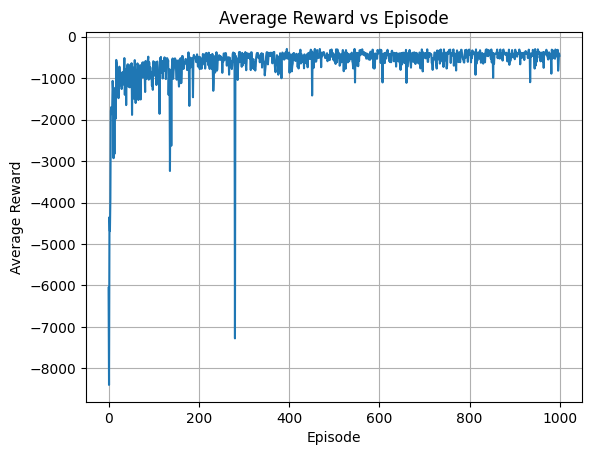

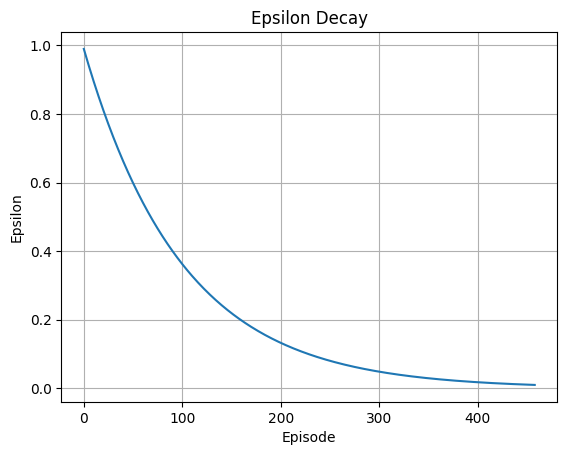

In [14]:

    # Draw reward vs episode plot
    import matplotlib.pyplot as plt
    plt.plot(score_list)
    plt.grid('on')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward vs Episode')
    plt.show()

     # Draw epsilon decay plot
    plt.plot(agent.epsilon_decay_list)
    plt.grid('on')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')
    plt.show()

In [9]:
state_dim = 3
action_dim = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQN(state_dim, action_dim).to(device)
policy_net.load_state_dict(torch.load('pendulum_dqn.pth', map_location=torch.device('cpu')))
policy_net.eval()


DQN(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1000, bias=True)
)

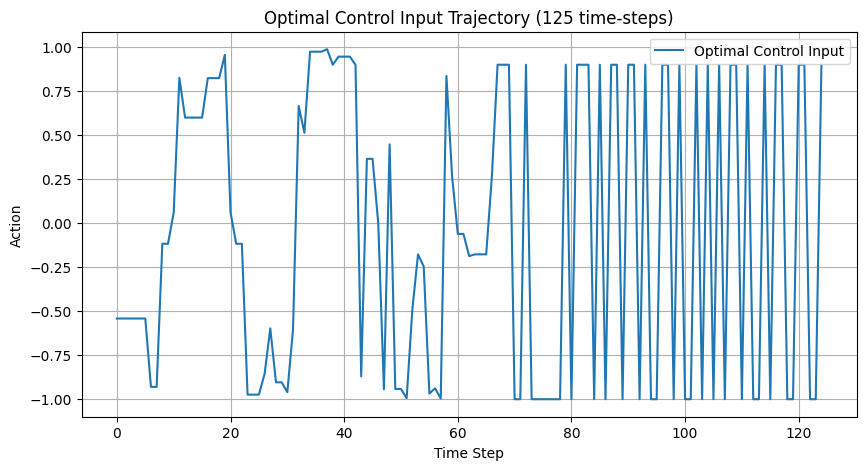

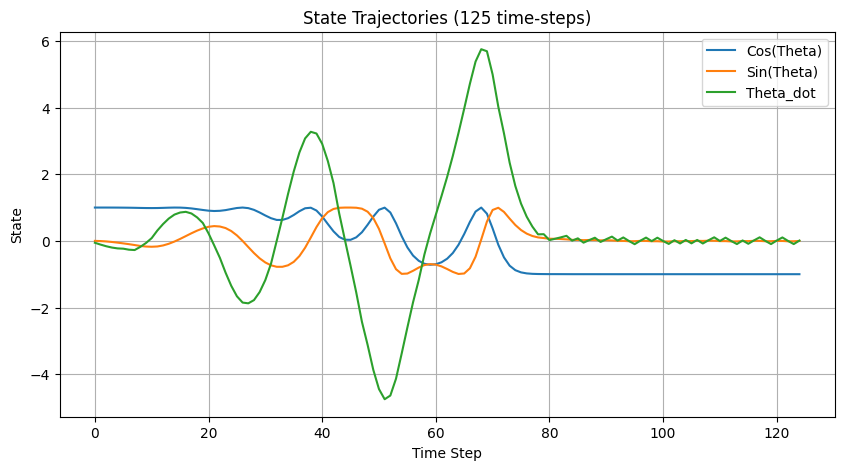

In [26]:
mass = 1.5
length = 0.8
damping = 0.2

initial_state = np.array([1.0, 0.0, 0.0])  # Example initial state

# Define time steps
num_steps = 125
dt = 0.1

# Initialize arrays to store state trajectories
cos_theta_traj = []
sin_theta_traj = []
theta_dot_traj = []
action_traj = []

# Simulate pendulum dynamics and store state trajectories
state = initial_state
for _ in range(num_steps):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    action = policy_net(state_tensor).argmax().item()
    action_traj.append(2*(action-500)/1000)

    next_state = simulate_pendulum(state, np.array([action]), mass, length, damping)
    cos_theta_traj.append(next_state[0])
    sin_theta_traj.append(next_state[1])
    theta_dot_traj.append(next_state[2])

    state = next_state

# Plot optimal control input trajectory
plt.figure(figsize=(10, 5))
plt.plot(action_traj, label='Optimal Control Input')
plt.xlabel('Time Step')
plt.ylabel('Action')
plt.title('Optimal Control Input Trajectory ('+str(num_steps)+' time-steps)')
plt.legend()
plt.grid(True)
plt.show()

# Plot state trajectories
plt.figure(figsize=(10, 5))
plt.plot(cos_theta_traj, label='Cos(Theta)')
plt.plot(sin_theta_traj, label='Sin(Theta)')
plt.plot(theta_dot_traj, label='Theta_dot')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.title('State Trajectories ('+str(num_steps)+' time-steps)')
plt.legend()
plt.grid(True)
plt.show()